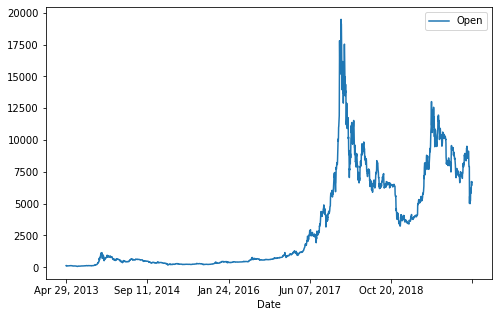

In [1]:
import pandas as pd

bitcoin = pd.read_csv('bitcoin_day.csv')
bitcoin.plot(x='Date', y='Open', figsize=(8,5))
bitcoin['Date'] = pd.to_datetime(bitcoin['Date'])

<AxesSubplot:xlabel='Date'>

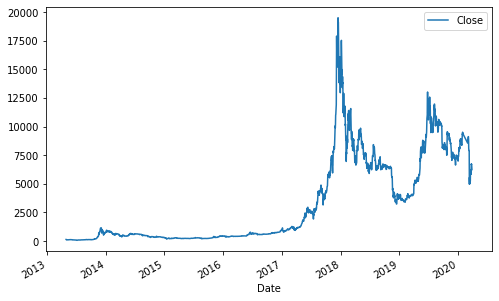

In [2]:
bitcoin.plot(x='Date', y='Close', figsize=(8,5))

In [3]:
import numpy as np
train = np.asarray(bitcoin[bitcoin['Date'] < '2017-06-01']['Close'])
test = np.asarray(bitcoin[bitcoin['Date'] >= '2017-06-01']['Close'])

In [4]:
train

array([ 144.54,  139.  ,  116.99, ..., 2255.61, 2175.47, 2286.41])

In [5]:
window=20
X_train = np.asarray([train[i:i+window] for i in range(len(train)-window - 1)])[:,:,np.newaxis]
Y_train = np.asarray([train[i:i+window] for i in range(1, len(train)-window)])[:,:,np.newaxis]
X_test = np.asarray([test[i:i+window] for i in range(len(test)-window-1)])[:,:,np.newaxis]
Y_test = np.asarray([test[i:i+window] for i in range(len(test)-window)])[:,:,np.newaxis]

In [6]:
from vrnngan import VRNNGRUGAN
from tensorflow import keras

timesteps = X_train.shape[1]
feature_space = X_train.shape[2]
latent_dim = 128
model = VRNNGRUGAN(feature_space, latent_dim, timesteps)
model.compile(keras.optimizers.Adam(lr=0.0001), keras.optimizers.Adam(lr=0.000001))
model.fit(X_train, Y_train, batch_size= 16, epochs=1)

/mnt/c/Users/jchle/Work/Thesis/VAECJ/bash_venv/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


93/93 [==============================] - 17s 34ms/step - total_loss: 337919.0312 - loss: 353755.6084 - kl: 38.8919 - discrim_loss: 1.0989 - discrim_loss_fake: 0.5272 - discrim_loss_real: 1.8474 - misled_loss: 1.4896


In [126]:
from importlib import reload
import vrnngan
vrnngan = reload(vrnngan)

In [21]:
X_test[0]

array([[2407.88],
       [2488.55],
       [2515.35],
       [2511.81],
       [2686.81],
       [2863.2 ],
       [2732.16],
       [2805.62],
       [2823.81],
       [2947.71],
       [2958.11],
       [2659.63],
       [2717.02],
       [2506.37],
       [2464.58],
       [2518.56],
       [2655.88],
       [2548.29],
       [2589.6 ],
       [2721.79]])

In [128]:
results = model.rec_gen(X_test[800], 30)

InvalidArgumentError: In[0] and In[1] has different ndims: [128] vs. [128,128] [Op:MatMul]

In [117]:
a = np.asarray([[[1,2]]])
a

array([[[1, 2]]])

(0.0, 3000.0)

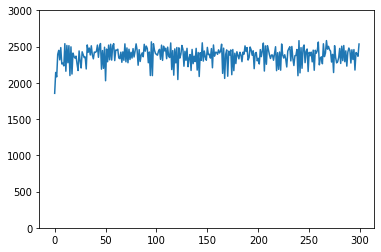

In [61]:
import matplotlib.pyplot as plt
results = [np.ndarray.flatten(arr) for arr in results]
plt.plot(results)
plt.ylim([0,3000])

(0.0, 3000.0)

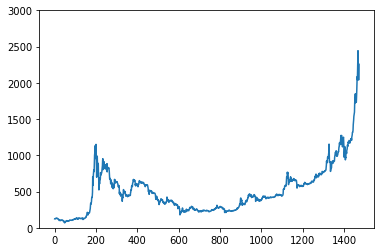

In [13]:
import matplotlib.pyplot as plt
plt.plot(X_train[:,-1,:])
plt.ylim([0,3000])

In [71]:
import tensorflow as tf
tf.keras.backend.clear_session()

In [54]:
outputs, z, q_mu, p_mu, q_logvar, p_logvar = model.predict(X_test)

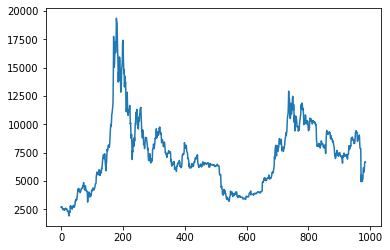

In [55]:
import matplotlib.pyplot as plt
plt.plot(outputs[:,-1,:], label='predicted')
# plt.plot(Y_test[:-1,-1,:], label='truth')
# plt.legend()
# plt.show()


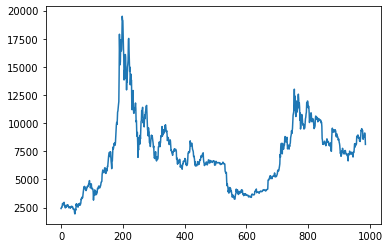

In [56]:
plt.plot(Y_test[:,0,:])

In [10]:
X_test.shape

(985, 20, 1)

In [57]:
def np_kl_gauss(posterior_means, prior_means, posterior_log_var, prior_log_var):
    kl = prior_log_var - posterior_log_var + (np.exp(posterior_log_var) + 
                                       np.square(posterior_means - prior_means)) / np.exp(prior_log_var) - 1
    kl = 0.5 * np.sum(kl)
    return kl

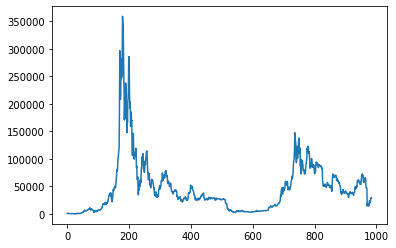

In [76]:
kl_values = []

for i in range(outputs.shape[0]):
    kl_vals = []
    for j in range(outputs.shape[1]):
        kl_vals.append(np_kl_gauss(q_mu[i][j], p_mu[i][j], q_logvar[i][j], p_logvar[i][j]))
    kl_values.append(kl_vals)

kl_sums = [np.sum(kl) for kl in kl_values]
kl_firsts = [kl[-1] for kl in kl_values]
plt.plot(kl_firsts)

In [43]:
kl_values

[[14891.05078125,
  3373.982421875,
  1521.222900390625,
  1179.486328125,
  1435.3656005859375,
  1803.661376953125,
  1428.6578369140625,
  1587.451904296875,
  1620.341552734375,
  1942.4560546875,
  1967.49267578125,
  1222.847900390625,
  1349.9638671875,
  913.30908203125,
  837.7374267578125,
  935.8107299804688,
  1212.967041015625,
  992.4140625,
  1074.2470703125,
  1360.142578125],
 [15905.8671875,
  3114.40576171875,
  1433.11376953125,
  1548.07470703125,
  1873.27490234375,
  1453.8248291015625,
  1596.297119140625,
  1626.234619140625,
  1945.8936767578125,
  1969.08935546875,
  1223.4190673828125,
  1350.2581787109375,
  913.4884033203125,
  837.8323974609375,
  935.8316650390625,
  1212.943603515625,
  992.3722534179688,
  1074.1754150390625,
  1360.0400390625,
  1285.9219970703125],
 [16250.416015625,
  3064.0908203125,
  1963.2344970703125,
  2045.79931640625,
  1522.248046875,
  1637.2744140625,
  1650.490478515625,
  1961.512451171875,
  1977.8055419921875,
  1226.

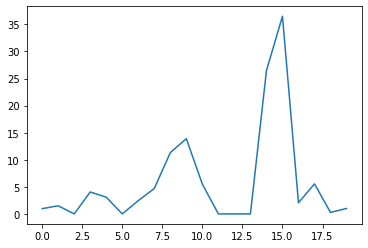

In [95]:
samples = model.generate(X_test[0])
plt.plot(samples[0][:,-1,:])

In [97]:
X_test[0].shape

(20, 1)

In [102]:
model.rec_gen(X_test[0], 50)

InvalidArgumentError: In[0] and In[1] has different ndims: [128] vs. [128,128] [Op:MatMul]

# LSTM Benchmark

In [185]:
timesteps = X_train.shape[1]
latent_dim = 128
feature_space = X_train.shape[2]

lstm_input = keras.layers.Input(shape=(timesteps, feature_space))
lstm = keras.layers.LSTM(latent_dim, return_sequences=True)(lstm_input)
output = keras.layers.TimeDistributed(keras.layers.Dense(feature_space))(lstm)

lstm_model = keras.Model(lstm_input, output)
lstm_model.compile(keras.optimizers.Adam(lr=0.001), loss='mean_squared_error')
lstm_model.fit(X_train, Y_train, batch_size= 8, epochs=300)

/mnt/c/Users/jchle/Work/Thesis/VAECJ/bash_venv/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/300
185/185 [==============================] - 2s 6ms/step - loss: 327205.5312
Epoch 2/300
185/185 [==============================] - 1s 6ms/step - loss: 299336.9688
Epoch 3/300
185/185 [==============================] - 1s 6ms/step - loss: 278403.0938
Epoch 4/300
185/185 [==============================] - 1s 7ms/step - loss: 260055.5312
Epoch 5/300
185/185 [==============================] - 1s 8ms/step - loss: 243626.4062
Epoch 6/300
185/185 [==============================] - 1s 7ms/step - loss: 228576.1094
Epoch 7/300
185/185 [==============================] - 1s 6ms/step - loss: 214702.0312
Epoch 8/300
185/185 [==============================] - 1s 6ms/step - loss: 201810.4688
Epoch 9/300
185/185 [==============================] - 1s 6ms/step - loss: 189795.9531
Epoch 10/300
185/185 [==============================] - 1s 6ms/step - loss: 178502.2969
Epoch 11/300
185/185 [==============================] - 1s 7ms/step - loss: 167989.6250
Epoch 12/300
185/185 [===================

185/185 [==============================] - 1s 6ms/step - loss: 5500.5449
Epoch 190/300
185/185 [==============================] - 1s 6ms/step - loss: 5361.7510
Epoch 191/300
185/185 [==============================] - 1s 6ms/step - loss: 5331.1733
Epoch 192/300
185/185 [==============================] - 1s 6ms/step - loss: 5461.0957
Epoch 193/300
185/185 [==============================] - 1s 6ms/step - loss: 5411.1460
Epoch 194/300
185/185 [==============================] - 1s 6ms/step - loss: 5347.7280
Epoch 195/300
185/185 [==============================] - 1s 6ms/step - loss: 5317.0791
Epoch 196/300
185/185 [==============================] - 1s 6ms/step - loss: 5210.7144
Epoch 197/300
185/185 [==============================] - 1s 6ms/step - loss: 5160.9429
Epoch 198/300
185/185 [==============================] - 1s 6ms/step - loss: 5112.7168
Epoch 199/300
185/185 [==============================] - 1s 6ms/step - loss: 5059.1841
Epoch 200/300
185/185 [==============================] - 

In [11]:
import matplotlib.pyplot as plt
outputs = lstm_model.predict(X_test)
plt.plot(outputs[:,-1,:])
plt.ylim([0,2000])

NameError: name 'lstm_model' is not defined

# VRNN Benchmark

In [240]:
from vrnngan import VRNNGRU
timesteps = X_train.shape[1]
latent_dim = 128
feature_space = X_train.shape[2]
rvae = VRNNGRU(feature_space, latent_dim, timesteps)
rvae.compile(optimizer=keras.optimizers.Adam(lr=0.001))
rvae.fit(X_train, Y_train, batch_size=8, epochs=100)

/mnt/c/Users/jchle/Work/Thesis/VAECJ/bash_venv/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/100
185/185 [==============================] - 5s 16ms/step - total_loss: 10826515.0000 - loss: 18735869.6667 - kl: 4158043.7121
Epoch 2/100
185/185 [==============================] - 3s 16ms/step - total_loss: 203996.4375 - loss: 269272.3032 - kl: 17572.4173
Epoch 3/100
185/185 [==============================] - 3s 16ms/step - total_loss: 37280.7344 - loss: 19493.2887 - kl: 20496.8164
Epoch 4/100
185/185 [==============================] - 3s 16ms/step - total_loss: 34038.6719 - loss: 15472.6445 - kl: 20527.9434
Epoch 5/100
185/185 [==============================] - 3s 16ms/step - total_loss: 33186.0664 - loss: 14160.2806 - kl: 18355.6740
Epoch 6/100
185/185 [==============================] - 3s 16ms/step - total_loss: 32413.2402 - loss: 15073.9120 - kl: 18457.6981
Epoch 7/100
185/185 [==============================] - 3s 16ms/step - total_loss: 31776.0293 - loss: 13768.0226 - kl: 16761.7706
Epoch 8/100
185/185 [==============================] - 3s 16ms/step - total_loss: 30542

In [237]:
outputs, z, q_mu, p_mu, q_logvar, p_logvar = rvae.predict(X_test)

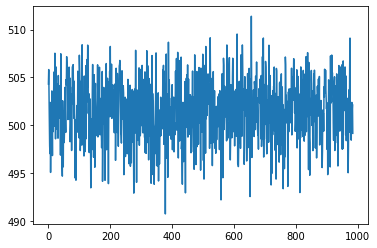

In [239]:
plt.plot(outputs[:,-1,:])